# 20180723 Test

In [1]:
from osgeo import gdal

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import quagmire
from quagmire import tools as meshtools

from scipy.ndimage import imread
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import LightSource

## 1. Import coastline shapefile

This requires pyshp to be installed. We scale the points to match the dimensions of the DEM we'll use later.

In [2]:
## Define region of interest (here Japan) 

japan_bounds = (125.0, 30.0, 155.0, 42.0)

aus_bounds = (110, -45, 160, -10)

taiwan_bounds = (120, 21, 123, 26)

minX, minY, maxX, maxY = taiwan_bounds


In [3]:
xres = 1000
yres = 1000

xx = np.linspace(minX, maxX, xres)
yy = np.linspace(minY, maxY, yres)
x1, y1 = np.meshgrid(xx,yy)
x1 += np.random.random(x1.shape) * 0.2 * (maxX-minX) / xres
y1 += np.random.random(y1.shape) * 0.2 * (maxY-minY) / yres

x1 = x1.flatten()
y1 = y1.flatten()

pts = np.stack((x1, y1)).T

In [4]:
# gtiff = gdal.Open("../../data/ETOPO1_Ice_c_geotiff.tif")
gtiff = gdal.Open("/home/student.unimelb.edu.au/nengl/Codes/ETOPO1_Ice_c_geotiff.tif")
width = gtiff.RasterXSize
height = gtiff.RasterYSize
gt = gtiff.GetGeoTransform()
img = gtiff.GetRasterBand(1).ReadAsArray().T

img = np.fliplr(img)

# plt.imshow(img)

sliceLeft   = int(180+minX) * 60
sliceRight  = int(180+maxX) * 60
sliceBottom = int(90+minY) * 60
sliceTop    = int(90+maxY) * 60

LandImg = img[ sliceLeft:sliceRight, sliceBottom:sliceTop].T
LandImg = np.flipud(LandImg)

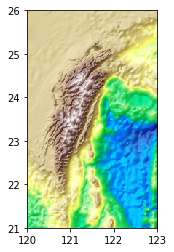

In [5]:
fig = plt.figure(1, figsize=(5,4))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')
plt.show()

In [6]:
coords =np.stack((y1, x1)).T
coords2 =np.stack((y1, x1))

im_coords = coords.copy()
im_coords[:,0] -= minY
im_coords[:,1] -= minX
im_coords[:,0] *= LandImg.shape[0] / (maxY-minY) 
im_coords[:,1] *= LandImg.shape[1] / (maxX-minX) 
im_coords[:,0] =  LandImg.shape[0] - im_coords[:,0]
 

In [7]:
from scipy import ndimage

meshheights = ndimage.map_coordinates(LandImg, im_coords.T, order=3, mode='nearest').astype(np.float)

# Fake geoid for this particular region
# meshheights -= 40.0 * (y1 - minY) / (maxY - minY)

In [8]:
## Filter out the points we don't want at all 

points = meshheights > -500 

m1s = meshheights[points]
x1s = x1[points]
y1s = y1[points]

submarine = m1s < 0.0
subaerial = m1s >= 0.0

/home/student.unimelb.edu.au/nengl/.local/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


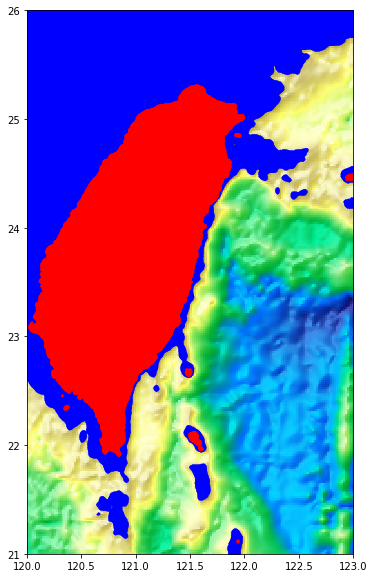

In [9]:
fig = plt.figure(1, figsize=(14,10))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')

ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')
ax.scatter(x1s[submarine], y1s[submarine], s=0.5, color="Blue")
ax.scatter(x1s[subaerial], y1s[subaerial], s=1.0, color="Red")

fig.show()

In [10]:
## triangulate

import stripy

mesh0 = stripy.cartesian.Triangulation(x1s, y1s, permute=True, tree=True)

## I think we only need the tree, not the triangulation

In [11]:
d, n = mesh0.nearest_vertices(mesh0.points[submarine][:,0], mesh0.points[submarine][:,1], k=25)

candidates = np.where(np.any(subaerial[n],axis=1))
keepers = n[candidates,0]


In [12]:
boundary = np.zeros_like(subaerial)
boundary[keepers] = True

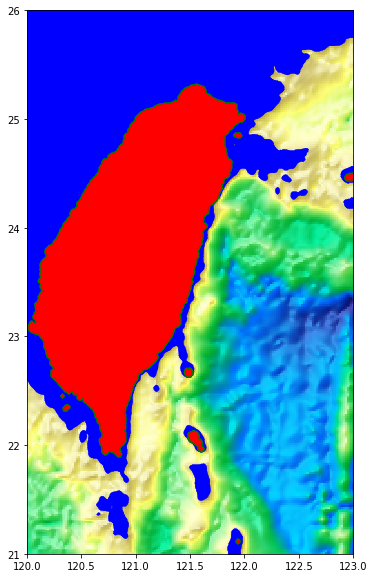

In [13]:
fig = plt.figure(1, figsize=(14,10))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')

ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')

ax.scatter(x1s[submarine], y1s[submarine], s=0.5, color="Blue")
ax.scatter(x1s[boundary],  y1s[boundary],  s=0.5, color="Green")
ax.scatter(x1s[subaerial], y1s[subaerial], s=0.25, color="Red")

fig.show()

In [14]:
x2s = x1s[subaerial | boundary]
y2s = y1s[subaerial | boundary]
bmask2 = subaerial[subaerial | boundary]

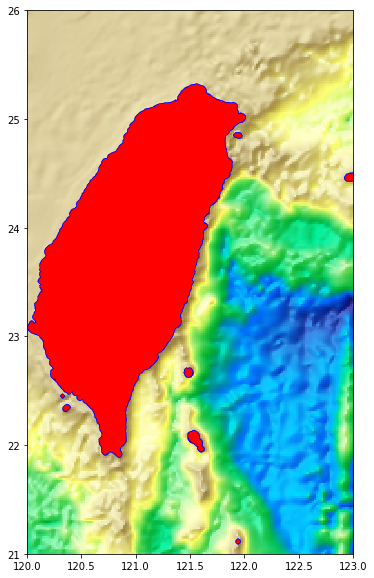

In [15]:
fig = plt.figure(1, figsize=(14,10))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')

ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')

ax.scatter(x2s[~bmask2],  y2s[~bmask2],  s=0.5, color="blue")
ax.scatter(x2s[ bmask2],  y2s[ bmask2], s=1.0, color="Red")

fig.show()

### 3. Create the DM

The points are now read into a DM and refined so that we can achieve very high resolutions. Refinement is achieved by adding midpoints along line segments connecting each point.

In [16]:
DM = meshtools.create_DMPlex_from_points(x2s, y2s, bmask2, refinement_steps=0)

In [17]:
# mesh = quagmire.SurfaceProcessMesh(DM, verbose=True, permute=True)


mesh = quagmire.SurfaceProcessMesh(DM, downhill_neighbours=1)
# %psource quagmire.SurfaceProcessMesh

0 - Delaunay triangulation 2.566327s
0 - Calculate node weights and area 0.026592s
0 - Find boundaries 0.002156s
0 - cKDTree 0.029959s
0 - Construct neighbour cloud array 1.18995s
0 - Construct rbf weights 0.295724s


In [18]:
x2r = mesh.tri.x
y2r = mesh.tri.y
simplices = mesh.tri.simplices
bmaskr = mesh.bmask

In [19]:
## Now re-do the allocation of points to the surface.
## In parallel this will be done process by process for a sub-set of points

coords = np.stack((y2r, x2r)).T

im_coords = coords.copy()
im_coords[:,0] -= minY
im_coords[:,1] -= minX

im_coords[:,0] *= LandImg.shape[0] / (maxY-minY) 
im_coords[:,1] *= LandImg.shape[1] / (maxX-minX) 
im_coords[:,0] =  LandImg.shape[0] - im_coords[:,0]

In [20]:
from scipy import ndimage

spacing = 1.0
coords = np.stack((y2r, x2r)).T / spacing

meshheights = ndimage.map_coordinates(LandImg, im_coords.T, order=3, mode='nearest')
meshheights = mesh.rbf_smoother(meshheights, iterations=2)

raw_height = meshheights.copy() * 0.001

# meshheights -= 40.0 * (y2r - minY) / (maxY - minY)

In [21]:
subaerial =  meshheights >= -0.02
submarine = ~subaerial
mesh.bmask = subaerial

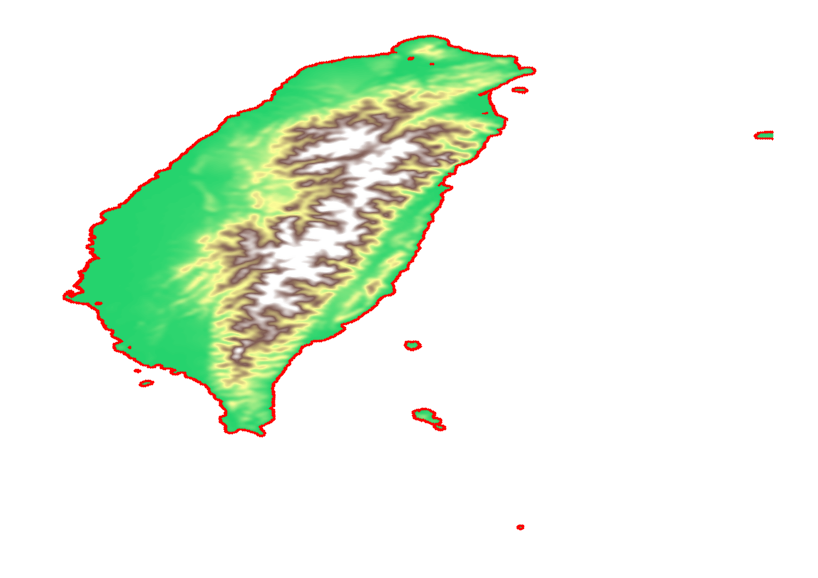

In [22]:
fig = plt.figure(1, figsize=(14, 10))
ax = fig.add_subplot(111)
ax.axis('off')

sc = ax.scatter(x2r[subaerial], y2r[subaerial], s=0.5,  c=meshheights[subaerial], cmap=cm.terrain, vmin=-1000.0, vmax=2500)
sc = ax.scatter(x2r[submarine], y2r[submarine], s=0.25, c="Red", alpha=1.0)
# sc = ax.scatter(x2r[hmask], y2r[hmask], s=0.5, c="Blue")


#fig.colorbar(sc, ax=ax, label='height')
fig.show()

In [23]:
# for i in range(0, 10):
#     meshheights = mesh.handle_low_points(0.0, 20)
#     mesh.update_height(meshheights)
#     low_points = mesh.identify_low_points()
#     print low_points.shape[0]
  
# m v km !

mesh.update_height(meshheights*0.001)
gradient_max = mesh.slope.max()
gradient_mean = mesh.slope.mean()
flat_spots = np.where(mesh.slope < gradient_mean*0.01)[0]
low_points = mesh.identify_low_points()

nodes = np.arange(0, mesh.npoints)
lows =  np.where(mesh.down_neighbour[1] == nodes)[0]

# print statistics
print("mean gradient {}\nnumber of flat spots {}\nnumber of low points {}".format(gradient_mean,
                                                                                  flat_spots.size,
                                                                                  low_points.shape[0]))  

raw_heights = mesh.height.copy()


print low_points

0 - Compute slopes 3.276311s
0 - Build downhill matrices 0.524891s
mean gradient 10.9797849655
number of flat spots 7859
number of low points 217
[  1240   1265   1737   1771   3351   4199   5312  10438  10667  12399
  13383  13452  14234  15581  16123  16282  16349  16380  18792  20404
  22008  22419  26070  28244  28622  30547  32595  33315  33708  33863
  35161  35730  36275  36690  37729  38713  38877  39007  42276  43203
  43742  44221  44456  46585  47778  49057  49200  51180  51409  54132
  54995  55258  55732  57809  58619  59256  59622  60462  62020  62635
  63018  63166  65597  65768  65801  67817  67931  68145  69423  70358
  70895  72835  72860  73014  76047  76734  77807  78189  79238  79614
  82704  83323  83556  84579  87010  88896  89818  94221  94250  94831
  95404  95649 103248 103434 105343 108166 108540 109427 110769 110851
 112230 113782 114204 116404 116431 117066 117780 117846 118695 118997
 119933 120771 122398 122890 124641 125047 125312 126538 127548 128264
 1

In [24]:
its, flowpaths1 = mesh.cumulative_flow_verbose(mesh.area, verbose=True)
flowpaths1 = mesh.rbf_smoother(flowpaths1)

0: Max Delta - 0.534901872303 
10: Max Delta - 0.0044836533036 
20: Max Delta - 0.000287757532158 
30: Max Delta - 0.00037586676558 
40: Max Delta - 0.00037586676558 
50: Max Delta - 0.000282302619035 
60: Max Delta - 0.000249066224152 
70: Max Delta - 0.000249066224152 
80: Max Delta - 0.000249066224152 
90: Max Delta - 0.000249066224152 
100: Max Delta - 0.000249066224152 
110: Max Delta - 0.000249066224152 
120: Max Delta - 0.000121923145832 
130: Max Delta - 0.000121923145832 
140: Max Delta - 0.000116371327189 
150: Max Delta - 5.76034952453e-05 


## Low-point -filling algorithm

Most effective seems to be a little local patching followed by some iterations of the swamp fill. Repeat as necessary and check periodically to see what is actually happening.

In [25]:
## Local

new_heights=mesh.low_points_local_patch_fill(its=2)
mesh._update_height_partial(new_heights)
low_points2 = mesh.identify_low_points()
print low_points2.shape

## Flooding

for i in range(0,20):
    new_heights = mesh.low_points_swamp_fill(ref_height=-0.02)
    mesh._update_height_partial(new_heights)
    low_points2 = mesh.identify_low_points()
    if low_points2.shape[0] == 0:
        break # Careful - not parallel !
    print low_points2.shape

Low point local patch fill
 - Partial rebuild of downhill matrices 0.565229s
 - Partial rebuild of downhill matrices 0.687286s
Low point local patch fill  1.531171  seconds
 - Partial rebuild of downhill matrices 0.589295s
(175,)
161  iterations, time =  3.795804
Build low point catchments -  3.797025  seconds
0  Sort spills -  0.007802
0  Gather spill data -  0.000275999999999
0  Sort all spills -  0.000220999999996
 - Partial rebuild of downhill matrices 0.414868s
Low point swamp fill  4.331909  seconds
 - Partial rebuild of downhill matrices 0.40537s
(19,)
289  iterations, time =  6.331466
Build low point catchments -  6.332843  seconds
0  Sort spills -  0.00546
0  Gather spill data -  0.000127000000006
0  Sort all spills -  8.49999999986e-05
 - Partial rebuild of downhill matrices 0.407944s
Low point swamp fill  6.823815  seconds
 - Partial rebuild of downhill matrices 0.415334s
(1,)
289  iterations, time =  7.139901
Build low point catchments -  7.141311  seconds
0  Sort spills - 

In [26]:
mesh.update_height(new_heights)
lakes = mesh.height - raw_heights
# lakes[~mesh.bmask] = 0.0

print lakes.max(), mesh.height.max(), mesh.height.min()

0 - Compute slopes 2.32662s
0 - Build downhill matrices 0.410827s
0.43993124964444946 3.543873791308691 -0.02


In [27]:
its, flowpaths = mesh.cumulative_flow_verbose(np.ones_like(mesh.height), verbose=True)
flowpaths2 = mesh.rbf_smoother(flowpaths, iterations=1)

0: Max Delta - 8.0 
10: Max Delta - 18.0 
20: Max Delta - 19.0 
30: Max Delta - 28.0 
40: Max Delta - 28.0 
50: Max Delta - 28.0 
60: Max Delta - 28.0 
70: Max Delta - 30.0 
80: Max Delta - 36.0 
90: Max Delta - 36.0 
100: Max Delta - 36.0 
110: Max Delta - 36.0 
120: Max Delta - 36.0 
130: Max Delta - 36.0 
140: Max Delta - 36.0 
150: Max Delta - 36.0 
160: Max Delta - 36.0 
170: Max Delta - 36.0 
180: Max Delta - 36.0 
190: Max Delta - 36.0 
200: Max Delta - 36.0 
210: Max Delta - 36.0 
220: Max Delta - 36.0 
230: Max Delta - 21.0 
240: Max Delta - 21.0 
250: Max Delta - 21.0 
260: Max Delta - 21.0 
270: Max Delta - 16.0 
280: Max Delta - 16.0 


In [28]:
## Plane at zero height for visualization

minx = mesh.tri.x.min()
miny = mesh.tri.y.min()
maxx = mesh.tri.x.max()
maxy = mesh.tri.y.max()
refheight = -0.0005

bplanexy = np.array([ (minx, miny, refheight), 
                      (minx, maxy, refheight), 
                      (maxx, maxy, refheight), 
                      (maxx, miny, refheight)])

bplane_tri = [ (0, 1, 2), (0, 2, 3)]



In [29]:
flowpaths1a = flowpaths1.copy()
flowpaths1a[mesh.height < 0.0] = 0.00001

flowpaths2a = flowpaths2.copy()
flowpaths2a[mesh.height < 0.0] = 0.00001


In [30]:
manifold = np.reshape(mesh.coords, (-1,2))
manifold = np.insert(manifold, 2, values=raw_heights*0.1, axis=1)

import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1500,1000], near=-10.0)

topo  = lv.triangles("topography",  wireframe=False)
topo.vertices(manifold)
topo.indices(mesh.tri.simplices)
topo.values(raw_heights, 'topography')
topo["zmin"] = -0.05

topo.colourmap("(-1.0)#FFFFFF:1.0 (-0.01)#0099FF:1.0 (0.01)#AAAAAA:1.0 (0.5)#777777:1.0 (2.5)#555555:1.0" , logscale=False)   # Apply a built in colourmap


topo2  = lv.triangles("topography2",  wireframe=False)
topo2.vertices(manifold)
topo2.indices(mesh.tri.simplices)
topo2.values(mesh.height, 'topography')
topo2["zmin"] = -0.05

topo2.colourmap("(-1.0)#FFFFFF:0.0 (-0.01)#0099FF:0.3 (0.01)#FFFF99:1.0 (0.5)#33AA11:1.0 (2.5)#886644:1.0" , logscale=False, range=[0.0,1.0])   # Apply a built in colourmap

manifold = np.reshape(mesh.coords, (-1,2))
manifold = np.insert(manifold, 2, values=mesh.height*0.1, axis=1)


flowpath2 = lv.triangles("flow",  wireframe=False)
flowpath2.vertices(manifold+(0.0,0.0,0.02))
flowpath2.indices(mesh.tri.simplices)
flowpath2.values(flowpaths1a, label='flow1')
flowpath2.values(flowpaths2a, label='flow2')
flowpath2["zmin"] = -0.05
flowpath2.colourmap(["#FFFFFF:0.0 #0033FF:0.3 #000033"], logscale=True)   

## LAKES / SWAMPS

lakeheight = lakes.copy()
lakeheight[lakes > 0.0]  = mesh.height[lakes > 0.0]
lakeheight[lakes <= 0.0] = 0.0 # raw_heights[lakes <= 0.0] - 0.1

# manifold = np.reshape(mesh.coords, (-1,2))
# manifold = np.insert(manifold, 2, values=lakeheight*0.25, axis=1)

# lakeheight[lakes <= 0.0] = 0.0

lakeview = lv.triangles("lakes",  wireframe=False, colour="#00FFEE:0.5")
lakeview.vertices(manifold+(0.0,0.0,-0.002))
lakeview.indices(mesh.tri.simplices)
lakeview.values(lakeheight, 'lakes')
lakeview["zmin"] = -0.05

# lakeview.colourmap("(-1.0)#FFFFFF:0.0 (0.0)#FFFFFF:0.5 (0.05)#55FFEE:1.0 (1.0)#00FFEE:1.0" , logscale=False, range=[0.0,1.0])   # Apply a built in colourmap

bplane = lv.triangles('bplane', wireframe=False, colour=(0.5,0.7,0.9,1.0))
bplane.vertices(bplanexy)
bplane.indices(bplane_tri)



In [31]:

# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Panel()
lv.control.Checkbox(property='axis')
flowpath2.control.List(["flow1", "flow2"], property="colourby", value="flow2", command="reload")
lv.control.Command()
lv.control.ObjectList()
lv.control.show()

<IPython.core.display.Javascript object>


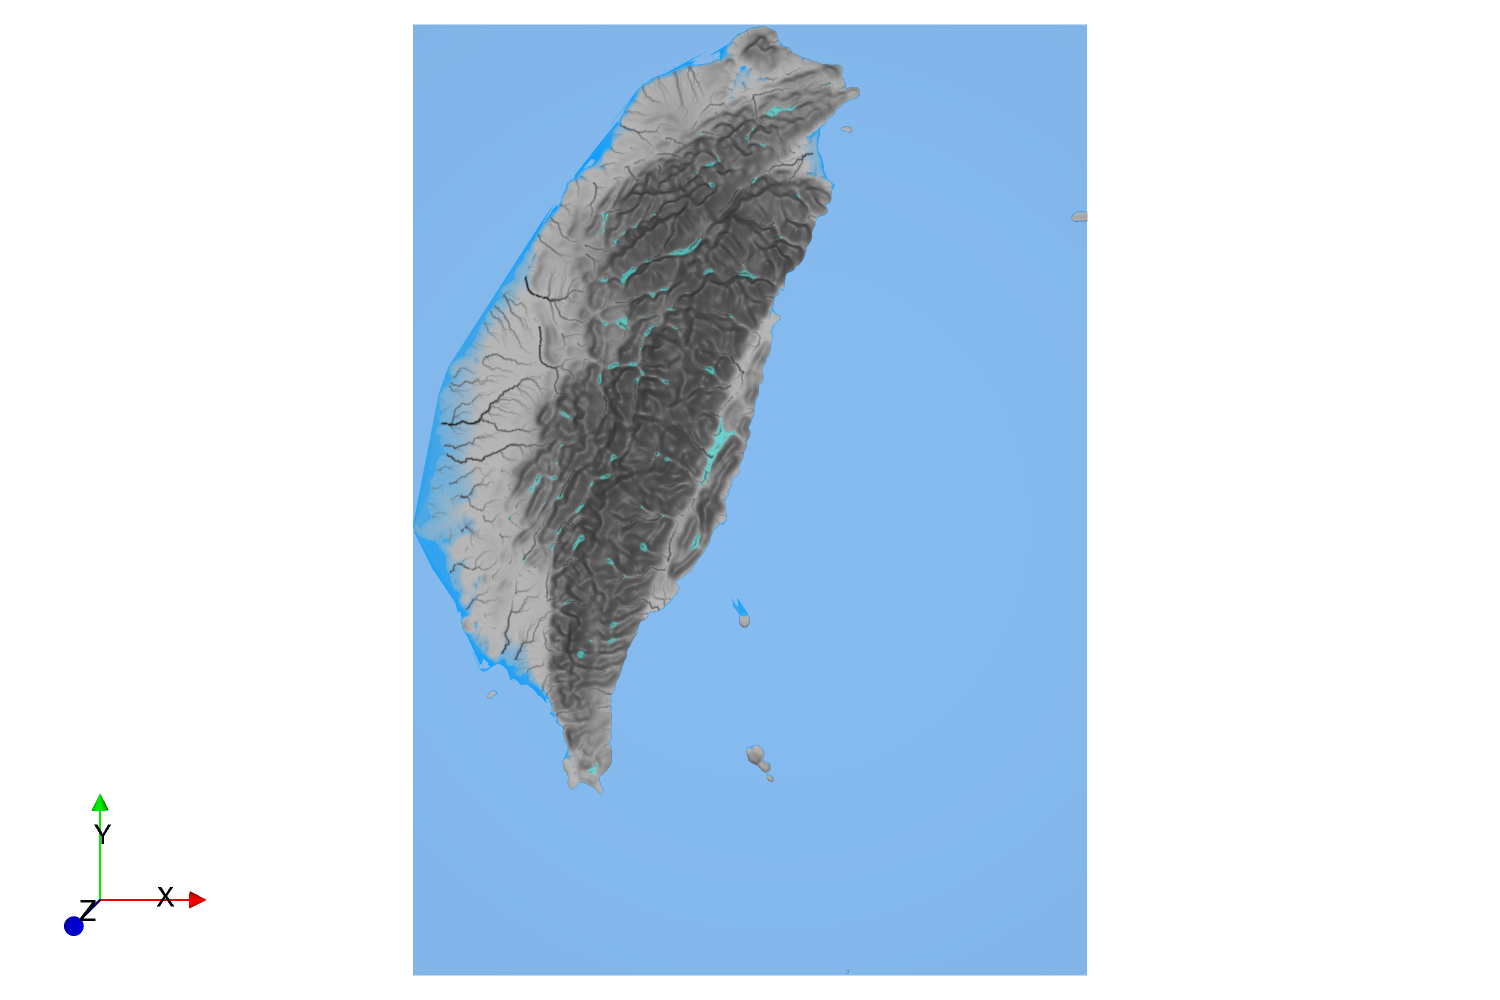

In [32]:
lv.display()

In [33]:
# 99 = 1

In [34]:
manifold = np.reshape(mesh.coords[mesh.bmask], (-1,2))
manifold = np.insert(manifold, 2, values=mesh.height[mesh.bmask]*0.25, axis=1)


In [35]:
import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

topo = lv.points(pointsize=2.0, pointtype=0)
topo.vertices(manifold)
topo.values(mesh.height[mesh.bmask], label='height')
# topo.values(np.sqrt(flowpaths), label='flow')

topo2 = lv.points(pointsize=2.0, pointtype=0)
topo2.vertices(manifold+(0.0,0.0,0.1))
# topo.values(mesh.height, label='height')
topo2.values(np.sqrt(flowpaths2[mesh.bmask]), label='flow1')


# topo3 = lv.points(pointsize=2.0, pointtype=0)
# topo3.vertices(manifold+(0.0,0.0,0.1))
# # topo.values(mesh.height, label='height')
# topo3.values(np.sqrt(flowpathsG2[bmaskr]), label='flowG')


topo.colourmap(["#004420", "#FFFFFF", "#444444"] , logscale=False, range=[-0.2, 1.0])   # Apply a built in colourmap
# topo.colourmap(["#FFFFFF:0.0", "#0033FF:0.3", "#000033"], logscale=False)   # Apply a built in colourmap
topo2.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap

pass




In [36]:
lv.window()

# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Checkbox(property='axis')
lv.control.Command()
lv.control.ObjectList()
lv.control.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


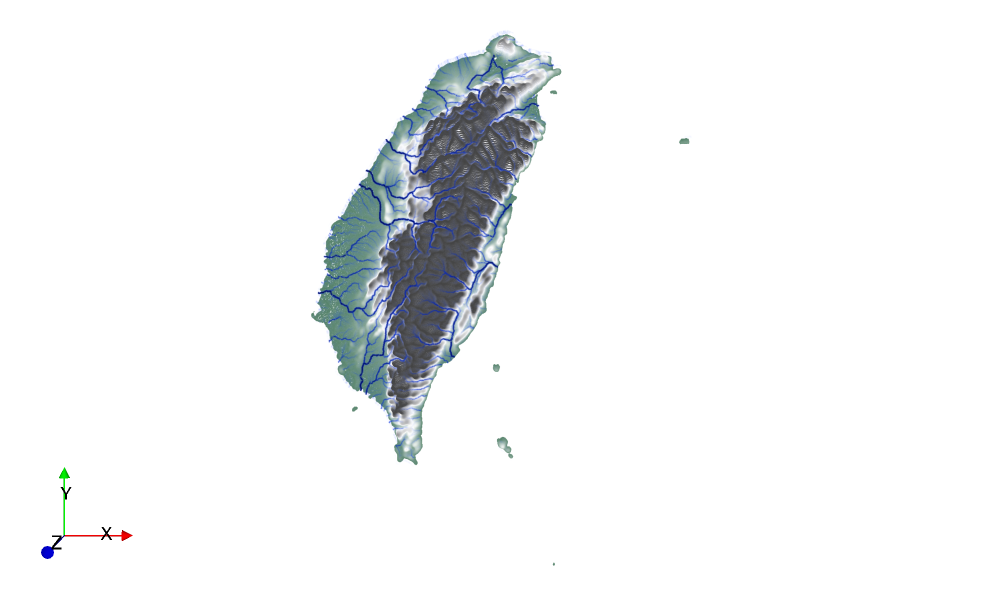

In [37]:
lv.display()

## 5. Save to HDF5

Save the mesh to an HDF5 file so that it can be visualised in Paraview or read into Quagmire another time. There are two ways to do this:

1. Using the `save_DM_to_hdf5` function in meshtools, or
2. Directly from trimesh interface using `save_mesh_to_hdf5` method.

Remember to execute `petsc_gen_xdmf.py austopo.h5` to create the XML file structure necessary to visualise the mesh in paraview.

In [38]:
# filename = 'NZTopo.h5'

# mesh.save_mesh_to_hdf5(filename)
# mesh.save_field_to_hdf5(filename, height=mesh.height, 
#                                   height0=raw_heights,
#                                   slope=mesh.slope, 
#                                   flow1=np.sqrt(flowpaths1),
#                                   flow2=np.sqrt(flowpaths2),
#                                   lakes = lakes)

# # to view in Paraview
# meshtools.generate_xdmf(filename)

## 6. Locating and viewing the outflow points

In [39]:
# mesh.downhill_neighbours = 2
# mesh.update_height(mesh.height)
outflows = mesh.identify_outflow_points()
print("Mesh has {} outflows".format(outflows.shape[0]))
print outflows
# %psource mesh.identify_outflow_points

Mesh has 2462 outflows
[     0      1      2 ... 222196 222197 222198]


<IPython.core.display.Javascript object>


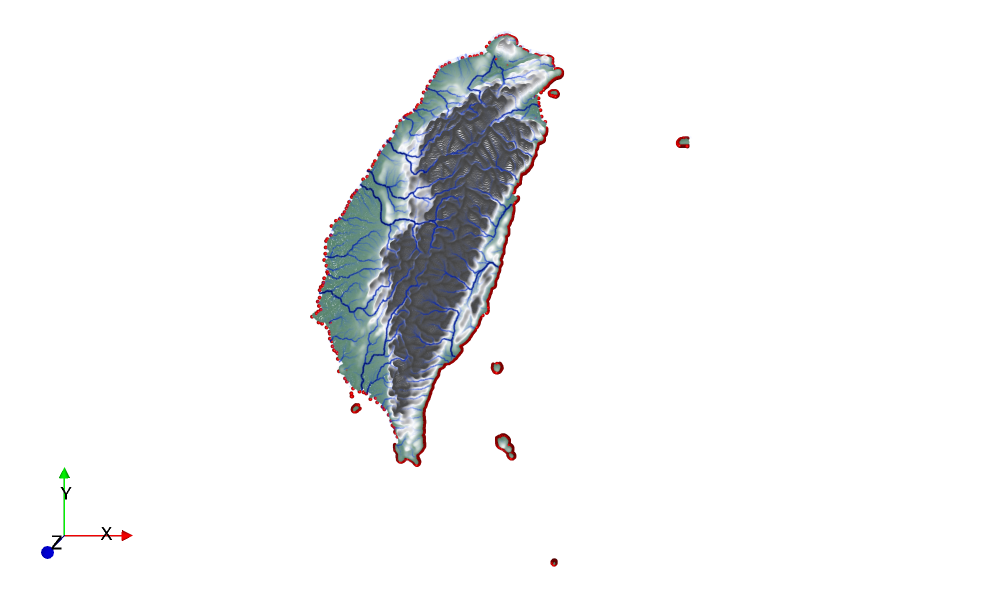

In [40]:
import lavavu

outpoints = np.column_stack([mesh.tri.points[outflows], mesh.height[outflows]])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

nodes = lv.points("nodes", pointsize=5.0, pointtype="shiny", colour="#FF0000" )
# nodes.vertices(low_points)
nodes.vertices(outpoints)

topo = lv.points(pointsize=2.0, pointtype=0)
topo.vertices(manifold)
topo.values(mesh.height[mesh.bmask], label='height')
# topo.values(np.sqrt(flowpaths), label='flow')

topo2 = lv.points(pointsize=2.0, pointtype=0)
topo2.vertices(manifold+(0.0,0.0,0.1))
# topo.values(mesh.height, label='height')
topo2.values(np.sqrt(flowpaths2[mesh.bmask]), label='flow1')

topo.colourmap(["#004420", "#FFFFFF", "#444444"] , logscale=False, range=[-0.2, 1.0])   # Apply a built in colourmap
topo2.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap

lv.window()
# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Checkbox(property='axis')
lv.control.Command()
lv.control.ObjectList()
lv.display()

## 7. Set neighbours to 1 and compute "uphill" connectivity

In [41]:
## Unique catchments requires the downhill matrix with downhill_neighbours=1
mesh.near_neighbours=1
mesh.update_height(mesh.height)

0 - Compute slopes 2.005299s
0 - Build downhill matrices 0.417029s


In [42]:
## Need a unique ID that works in parallel ... global node number would work but 
## not that easy to map to colours in lavavu 

from petsc4py import PETSc
outflows
outflowID = mesh.lgmap_row.apply(outflows.astype(PETSc.IntType))

# But on 1 proc, this is easier / better:

outflowID = np.array(range(0, outflows.shape[0]))
ctmt = mesh.uphill_propagation(outflows,  outflowID, its=99999, fill=-999999).astype(np.int)


289  iterations, time =  6.648373


## 8. Visualise the catchment information

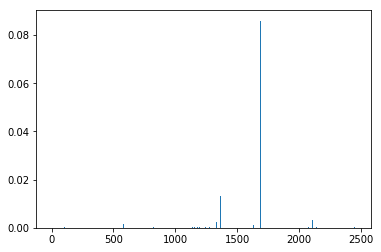

In [43]:
bins = range(0,ctmt.max()+2,1)
plt.hist(ctmt, bins,density=True, weights=None, cumulative=False, bottom=None,     
                histtype=u'bar', align=u'left', orientation=u'vertical',     
                rwidth=0.8, log=False, color=None, label=None, stacked=False,     
                hold=None) 
# plt.title("histogram") 
plt.show()

In [44]:
fre,N_categories = np.histogram(ctmt, bins, density=True)
fre_threshold = 3e-03
index = np.where(fre < fre_threshold)
outflows_new = np.delete(outflows,index)
print("Mesh has {} real outflows".format(outflows_new.shape[0]))

Mesh has 45 real outflows


In [45]:
import lavavu

outpoints = np.column_stack([mesh.tri.points[outflows_new], mesh.height[outflows_new]])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

nodes = lv.points("nodes", pointsize=5.0, pointtype="shiny", colour="#FF0000" )
# nodes.vertices(low_points)
nodes.vertices(outpoints)

topo = lv.points(pointsize=2.0, pointtype=0)
topo.vertices(manifold)
topo.values(mesh.height[mesh.bmask], label='height')
# topo.values(np.sqrt(flowpaths), label='flow')

topo2 = lv.points(pointsize=2.0, pointtype=0)
topo2.vertices(manifold+(0.0,0.0,0.1))
# topo.values(mesh.height, label='height')
topo2.values(np.sqrt(flowpaths2[mesh.bmask]), label='flow1')

topo.colourmap(["#004420", "#FFFFFF", "#444444"] , logscale=False, range=[-0.2, 1.0])   # Apply a built in colourmap
topo2.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap

lv.window()
# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
# lv.control.Checkbox(property='axis')
# lv.control.Command()
# lv.control.ObjectList()
# lv.display()

<IPython.core.display.Javascript object>

In [46]:
outflowID = np.array(range(0, outflows_new.shape[0]))
ctmt_new = mesh.uphill_propagation(outflows_new,  outflowID, its=99999, fill=-999999).astype(np.int)

289  iterations, time =  8.129985


In [47]:
import lavavu

outpoints = np.column_stack([mesh.tri.points[outflows_new], mesh.height[outflows_new]])
lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

nodes = lv.points("nodes", pointsize=5.0, pointtype="shiny", colour="#FF0000" )
nodes.vertices(outpoints)

####################
# topo = lv.triangles("topography", wireframe=False, opacity=1.0)
# topo.vertices(manifold)
# topo.indices(mesh.tri.simplices)

topo = lv.points("topography",pointsize=2.0, pointtype=0)
topo.vertices(manifold)
topo.values(mesh.height[mesh.bmask], label='height')
# topo.values(np.sqrt(flowpaths), label='flow')
topo.colourmap(["#004420", "#FFFFFF", "#444444"] , logscale=False, range=[-0.2, 1.0])   # Apply a built in colourmap

topo2 = lv.points("flow",pointsize=2.0, pointtype=0)
topo2.vertices(manifold+(0.0,0.0,0.1))
# topo.values(mesh.height, label='height')
topo2.values(np.sqrt(flowpaths2[mesh.bmask]), label='flow1')
topo2.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap

# topo3 = lv.triangles("catchment", wireframe=False)
topo3 = lv.points("catchment",pointsize=2.0, pointtype=0)
topo3.vertices(manifold+(0.0,0.0,0.1))
topo3.values(ctmt_new, label="catchments")
topo3.colourmap("spectral", discrete=True, range=[0, outflows_new.shape[0]-1])
topo3.colourbar()

# lv.window()
# lv.control.Checkbox(property='axis')
# lv.control.Command()
# lv.control.ObjectList()
# lv.display()

lv.control.Panel()
lv.control.ObjectList()
lv.control.show()

<IPython.core.display.Javascript object>

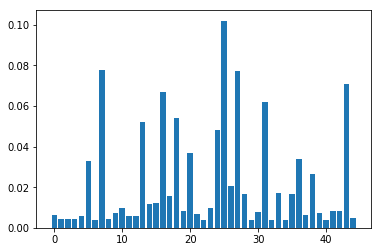

In [48]:
bins = range(0,ctmt_new.max()+2,1)
plt.hist(ctmt_new, bins,density=True,     
                weights=None, cumulative=False, bottom=None,     
                histtype=u'bar', align=u'left', orientation=u'vertical',     
                rwidth=0.8, log=False, color=None, label=None, stacked=False,     
                hold=None) 
# plt.title("histogram") 
plt.show()

In [49]:
ctmt_area = ctmt_new.copy()
ctmt_area_index = np.where (ctmt_new != 15)
ctmt_area[ctmt_area_index]= 0

In [50]:
import lavavu

outpoints = np.column_stack([mesh.tri.points[outflows_new], mesh.height[outflows_new]])
lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

nodes = lv.points("nodes", pointsize=5.0, pointtype="shiny", colour="#FF0000" )
nodes.vertices(outpoints)

####################
# topo = lv.triangles("topography", wireframe=False, opacity=1.0)
# topo.vertices(manifold)
# topo.indices(mesh.tri.simplices)

topo = lv.points("topography",pointsize=2.0, pointtype=0)
topo.vertices(manifold)
topo.values(mesh.height[mesh.bmask], label='height')
# topo.values(np.sqrt(flowpaths), label='flow')
topo.colourmap(["#004420", "#FFFFFF", "#444444"] , logscale=False, range=[-0.2, 1.0])   # Apply a built in colourmap

topo2 = lv.points("flow",pointsize=2.0, pointtype=0)
topo2.vertices(manifold+(0.0,0.0,0.1))
# topo.values(mesh.height, label='height')
topo2.values(np.sqrt(flowpaths2[mesh.bmask]), label='flow1')
topo2.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap

# topo3 = lv.triangles("catchment", wireframe=False)
topo3 = lv.points("catchment",pointsize=2.0, pointtype=0)
topo3.vertices(manifold+(0.0,0.0,0.1))
topo3.values(ctmt_area, label="catchments")
topo3.colourmap("spectral", discrete=True, range=[0, outflows_new.shape[0]-1])
topo3.colourbar()

# lv.window()
# lv.control.Checkbox(property='axis')
# lv.control.Command()
# lv.control.ObjectList()
# lv.display()

lv.control.Panel()
lv.control.ObjectList()
lv.control.show()

<IPython.core.display.Javascript object>